In [20]:
import torch
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
import perturbed_organics.utils as utils
import math


# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cmap = 'plasma_r'

In [21]:
input_type = 'delocalized'
mu = "0.0"
mu_val = float(mu)

folder_loc = f'/vast/sr6364/perturbed_organics/data/adaptive_phase_diagram/{input_type}'
folder_name = f'{input_type}_goe_symmetric_N_100_s_100_mu_{mu}_num_delta_100_num_input_100_num_trials_250_b0_1.0_b1_1.0_phase_diagram'
path = os.path.join(folder_loc, folder_name)

In [3]:
# Load parameters from the JSON file
param_file_path = os.path.join(path, 'parameters.json')
with open(param_file_path, 'r') as f:
    params = json.load(f)

# Extract parameters
N = params['N']
num_tasks = params['num_tasks']
num_delta = params['num_delta']
num_input = params['num_input']
num_trials = params['num_trials']
delta_range = np.array(params['delta_range'])
input_range = np.array(params['input_range'])

In [4]:
condition = torch.load(os.path.join(path, f'condition.pt'))
norm_fixed_point_y = torch.load(os.path.join(path, f'norm_fixed_point_y.pt'))
actual_fixed_point_y = torch.load(os.path.join(path, f'actual_fixed_point_y.pt'))
first_order_perturb_y = torch.load(os.path.join(path, f'first_order_perturb_y.pt'))

In [5]:
bool_stable = torch.where(condition == 2, True, False)
bool_limit_cycle = torch.where((condition == 0) | (condition == 3), True, False)
bool_unstable = torch.where(condition == 1, True, False)

In [10]:
# Proceed with plotting or further analysis
percent_stable = bool_stable.float().mean(dim=2) * 100
percent_notstable = 100 - percent_stable

percent_limit_cycle = bool_limit_cycle.float().mean(dim=2) * 100

percent_unstable = bool_unstable.float().mean(dim=2) * 100

In [7]:
# analytical prediction from perturbation theory
num_points_to_exclude = 3
idx = 0
norm_sol_idx = []
for input_norm in input_range:
    z = utils.make_input_drive(N=N, input_type=params['model_name'], input_norm=input_norm)
    norm_eqn = torch.sqrt(z ** 2 / (params['sigma']**2 + torch.norm(z) ** 2))
    norm_sol_idx.append(norm_eqn[idx].item())
norm_sol_idx = np.array(norm_sol_idx)

# analytical solution for the mean of the fixed point
G = (1 - np.sqrt(params['sigma'] ** 2 + input_range ** 2)) / (params['sigma'] ** 2 + input_range ** 2)
analytical_mean = norm_sol_idx + mu_val * input_range * G * (1 - input_range ** 2 / (params['sigma'] ** 2 + input_range ** 2)) / np.sqrt(N)


delta_c =  math.sqrt(2 * N) * analytical_mean / (G * input_range)
delta_c = delta_c[:-num_points_to_exclude]
new_input_norm = input_range[:-num_points_to_exclude]

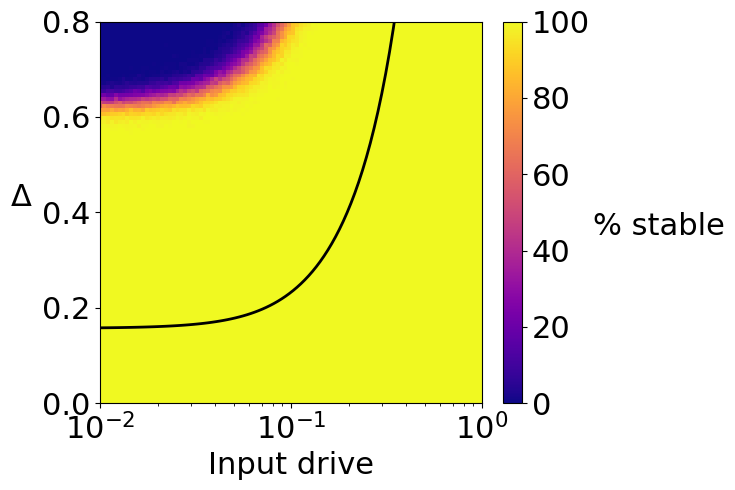

In [17]:
plt.figure(figsize=(7.5, 5))
norm = mcolors.Normalize(vmin=0, vmax=100, clip=False)
mesh = plt.pcolormesh(input_range, delta_range, percent_stable, cmap='plasma', norm=norm)
plt.plot(new_input_norm, delta_c, color='k', linewidth=2.0, label=r'$\Delta_c$')


plt.xscale('log')  # Ensure the axis is in log scale
colorbar = plt.colorbar(mesh, fraction=0.046, pad=0.04)
colorbar.ax.tick_params(labelsize=22)
colorbar.ax.set_ylabel(r"% stable", fontsize=22, rotation=0, labelpad=50)
plt.xlabel('Input drive', fontsize=22)
plt.ylabel(r'$\Delta$', fontsize=22, rotation=0, labelpad=15)
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(4))
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)


# Set the aspect ratio so that grid cells are square:
ax = plt.gca()
x_span = np.log10(input_range[-1]) - np.log10(input_range[0])
y_span = delta_range[-1] - delta_range[0]
ax.set_aspect(x_span / y_span, adjustable='box')

plt.xlim([input_range[0], input_range[-1]])
plt.ylim([delta_range[0], delta_range[-1]])

plt.tight_layout()
plt.savefig(f'../figures/fig4/percent_stable_{input_type}.png', bbox_inches='tight')
plt.savefig(f'../figures/fig4/percent_stable_{input_type}.svg', format='svg', bbox_inches='tight', dpi=300)
plt.savefig(f'../figures/fig4/percent_stable_{input_type}.eps', format='eps', bbox_inches='tight', dpi=300)
plt.show()


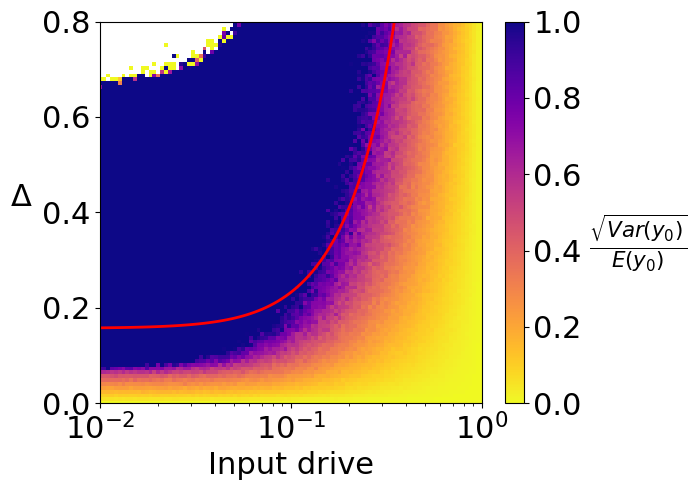

In [9]:
plt.figure(figsize=(7.5, 5))

idx = 0

norm = mcolors.Normalize(vmin=0, vmax=1, clip=True)

# calculate the avg ratio of deviation from norm fixed point for y
# y1_squared_norm = torch.norm(norm_fixed_point_y - actual_fixed_point_y, dim=3) ** 2 # deviation from the fixed point
# y0_squared_norm = torch.norm(norm_fixed_point_y, dim=3) ** 2
# y_ratio = y1_squared_norm / y0_squared_norm
# y_ratio_mean = torch.sqrt(torch.mean(y_ratio, dim=2))
# y_ratio_mean = torch.sqrt(torch.nanmean(y_ratio, dim=2))

# code for the standard deviation over mean criterion
y_val = actual_fixed_point_y[:, :, :, idx]
y_val_std = utils.nanstd(y_val, dim=2)
y_val_mean = torch.nanmean(y_val, dim=2)
y_ratio_mean = torch.abs(y_val_std / y_val_mean)

mesh = plt.pcolormesh(input_range, delta_range, y_ratio_mean, cmap=cmap, norm=norm)
plt.plot(new_input_norm, delta_c, color='red', linewidth=2.0, label=r'$\Delta_c$')


plt.xscale('log')  # Ensure the axis is in log scale
colorbar = plt.colorbar(mesh, fraction=0.046, pad=0.04)
colorbar.ax.tick_params(labelsize=22)
# colorbar.ax.set_ylabel(r"$\frac{||\mathbf{y}-\mathbf{y}_0||}{||\mathbf{y}_0||}$", fontsize=22, rotation=0, labelpad=40)
colorbar.ax.set_ylabel(r"$\frac{\sqrt{Var(y_0)}}{E(y_0)}$", fontsize=22, rotation=0, labelpad=40)
plt.xlabel('Input drive', fontsize=22)
plt.ylabel(r'$\Delta$', fontsize=22, rotation=0, labelpad=15)
# plt.title("Actual Mean Ratio of Norm Difference for y", fontsize=22)
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(4))
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

# Set the aspect ratio so that grid cells are square:
ax = plt.gca()
x_span = np.log10(input_range[-1]) - np.log10(input_range[0])
y_span = delta_range[-1] - delta_range[0]
ax.set_aspect(x_span / y_span, adjustable='box')

plt.xlim([input_range[0], input_range[-1]])
plt.ylim([delta_range[0], delta_range[-1]])

plt.tight_layout()
plt.savefig(f'../figures/fig4/norm_ratio_{input_type}.png', bbox_inches='tight')
plt.savefig(f'../figures/fig4/norm_ratio_{input_type}.svg', format='svg', bbox_inches='tight', dpi=300)
plt.savefig(f'../figures/fig4/norm_ratio_{input_type}.eps', format='eps', bbox_inches='tight', dpi=300)
plt.show()

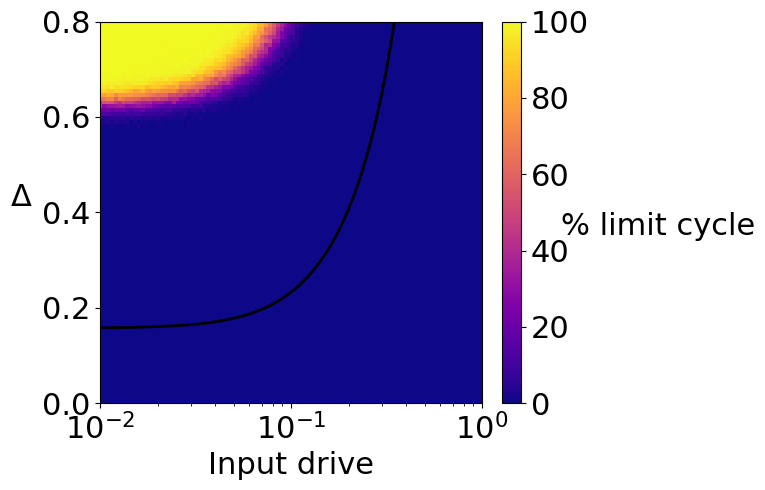

In [18]:
# We plot the percent of limit cycles detected

plt.figure(figsize=(7.5, 5))
norm = mcolors.Normalize(vmin=0, vmax=100, clip=False)
mesh = plt.pcolormesh(input_range, delta_range, percent_limit_cycle, cmap='plasma', norm=norm)
plt.plot(new_input_norm, delta_c, color='k', linewidth=2.0, label=r'$\Delta_c$')


plt.xscale('log')  # Ensure the axis is in log scale
colorbar = plt.colorbar(mesh, fraction=0.046, pad=0.04)
colorbar.ax.tick_params(labelsize=22)
colorbar.ax.set_ylabel(r"% limit cycle", fontsize=22, rotation=0, labelpad=50)
plt.xlabel('Input drive', fontsize=22)
plt.ylabel(r'$\Delta$', fontsize=22, rotation=0, labelpad=15)
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(4))
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)


# Set the aspect ratio so that grid cells are square:
ax = plt.gca()
x_span = np.log10(input_range[-1]) - np.log10(input_range[0])
y_span = delta_range[-1] - delta_range[0]
ax.set_aspect(x_span / y_span, adjustable='box')

plt.xlim([input_range[0], input_range[-1]])
plt.ylim([delta_range[0], delta_range[-1]])

plt.tight_layout()
plt.savefig(f'../figures/fig4/percent_limit_cycle_{input_type}.png', bbox_inches='tight')
plt.savefig(f'../figures/fig4/percent_limit_cycle_{input_type}.svg', format='svg', bbox_inches='tight', dpi=300)
plt.savefig(f'../figures/fig4/percent_limit_cycle_{input_type}.eps', format='eps', bbox_inches='tight', dpi=300)
plt.show()


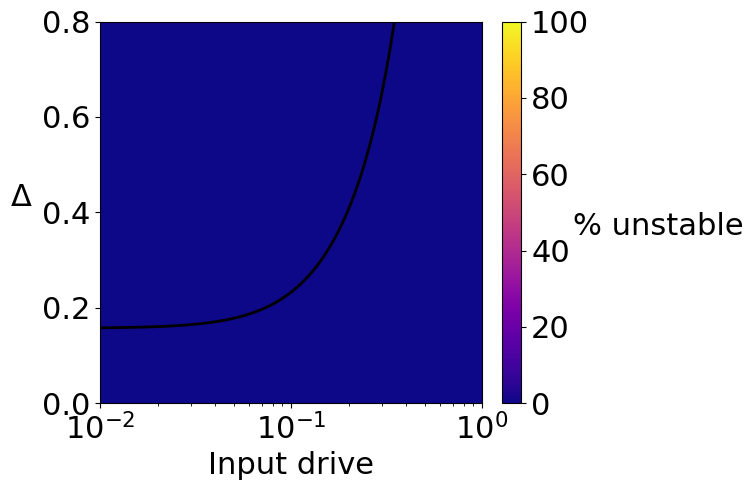

In [19]:
# We plot the percent of limit cycles detected

plt.figure(figsize=(7.5, 5))
norm = mcolors.Normalize(vmin=0, vmax=100, clip=False)
mesh = plt.pcolormesh(input_range, delta_range, percent_unstable, cmap='plasma', norm=norm)
plt.plot(new_input_norm, delta_c, color='k', linewidth=2.0, label=r'$\Delta_c$')


plt.xscale('log')  # Ensure the axis is in log scale
colorbar = plt.colorbar(mesh, fraction=0.046, pad=0.04)
colorbar.ax.tick_params(labelsize=22)
colorbar.ax.set_ylabel(r"% unstable", fontsize=22, rotation=0, labelpad=50)
plt.xlabel('Input drive', fontsize=22)
plt.ylabel(r'$\Delta$', fontsize=22, rotation=0, labelpad=15)
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(4))
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)


# Set the aspect ratio so that grid cells are square:
ax = plt.gca()
x_span = np.log10(input_range[-1]) - np.log10(input_range[0])
y_span = delta_range[-1] - delta_range[0]
ax.set_aspect(x_span / y_span, adjustable='box')

plt.xlim([input_range[0], input_range[-1]])
plt.ylim([delta_range[0], delta_range[-1]])

plt.tight_layout()
plt.savefig(f'../figures/fig4/percent_unstable_{input_type}.png', bbox_inches='tight')
plt.savefig(f'../figures/fig4/percent_unstable_{input_type}.svg', format='svg', bbox_inches='tight', dpi=300)
plt.savefig(f'../figures/fig4/percent_unstable_{input_type}.eps', format='eps', bbox_inches='tight', dpi=300)
plt.show()
